<a href="https://colab.research.google.com/github/basselkassem/predict_income_potential/blob/master/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Data Exploration:

The most improtant steps are:

- Identify quality issues (e.g. missing values, wrong measurements, …)
- Assess feature quality – how relevant is a certain measurement (e.g. use correlation matrix)
- Get an idea on the value distribution of your data using statistical measures and visualizations



# Importing libs

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy import stats

# Loading data

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data_path = "/content/gdrive/My Drive/Colab Notebooks/predict_income_potential/data/"
df = pd.read_csv(data_path + "init_data.csv")

In [0]:
df.head()

,age,workclass,final_weight,education,education_duration,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Print data info

In [0]:
print('-----------Data Shape---------')
print(df.shape)
print('-----------Missing values---------')
print(df.isnull().sum())
print('-----------Data types-------------')
print(df.dtypes)
print('-----------Memory usage (MB)------')
print(np.round(df.memory_usage(deep = True).sum() / 1024**2, 2))

-----------Data Shape---------
(48842, 15)
-----------Missing values---------
age                   0
workclass             0
final_weight          0
education             0
education_duration    0
marital_status        0
occupation            0
relationship          0
race                  0
sex                   0
capital_gain          0
capital_loss          0
hours_per_week        0
native_country        0
target                0
dtype: int64
-----------Data types-------------
age                    int64
workclass             object
final_weight           int64
education             object
education_duration     int64
marital_status        object
occupation            object
relationship          object
race                  object
sex                   object
capital_gain           int64
capital_loss           int64
hours_per_week         int64
native_country        object
target                object
dtype: object
-----------Memory usage (MB)------
30.26


# Utile functions

This table shows how to compute correlation between different types of features

![alt text](https://miro.medium.com/max/1000/1*6KNXPv-_3s7cJrcOQxbZCw.png)

In [0]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def print_corr(df, attr):
  lb_make = LabelEncoder()
  target_enc = lb_make.fit_transform(df['target'])
  
  if df[attr].dtype == 'object':
    lb_make = LabelEncoder()
    src_enc = lb_make.fit_transform(df[attr])
    corr = cramers_v(src_enc, target_enc)
    print('Corr between', attr, 'and the target: ', corr)
    return corr
  else:
    src_enc = df[attr]
    corr = stats.pointbiserialr(src_enc, target_enc)[0]
    print('Corr between', attr, 'and the target: ', corr)
    return corr

# Target

In [0]:
df['target'].value_counts()

 <=50K     24720
 <=50K.    12435
 >50K       7841
 >50K.      3846
Name: target, dtype: int64

The problem is a binary classification problem but we see that there is 4 labels. We need to remove the extra characters form the target columns

In [0]:
df['target'] = df['target'].str.replace('.', '')
df['target'] = df['target'].str.strip()
print('# class <=50k: ', 100 * round(len(df[df['target'] == '<=50K']) / len(df), 2), '%')
print('# class >50k: ', 100 * round(len(df[df['target'] == '>50K']) / len(df), 2), '%')

# class <=50k:  76.0 %
# class >50k:  24.0 %


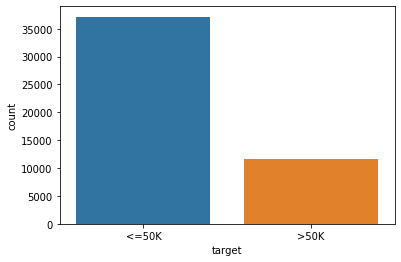

In [0]:
sns.countplot(x = 'target', data = df)
plt.show()

# Pair Plot

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


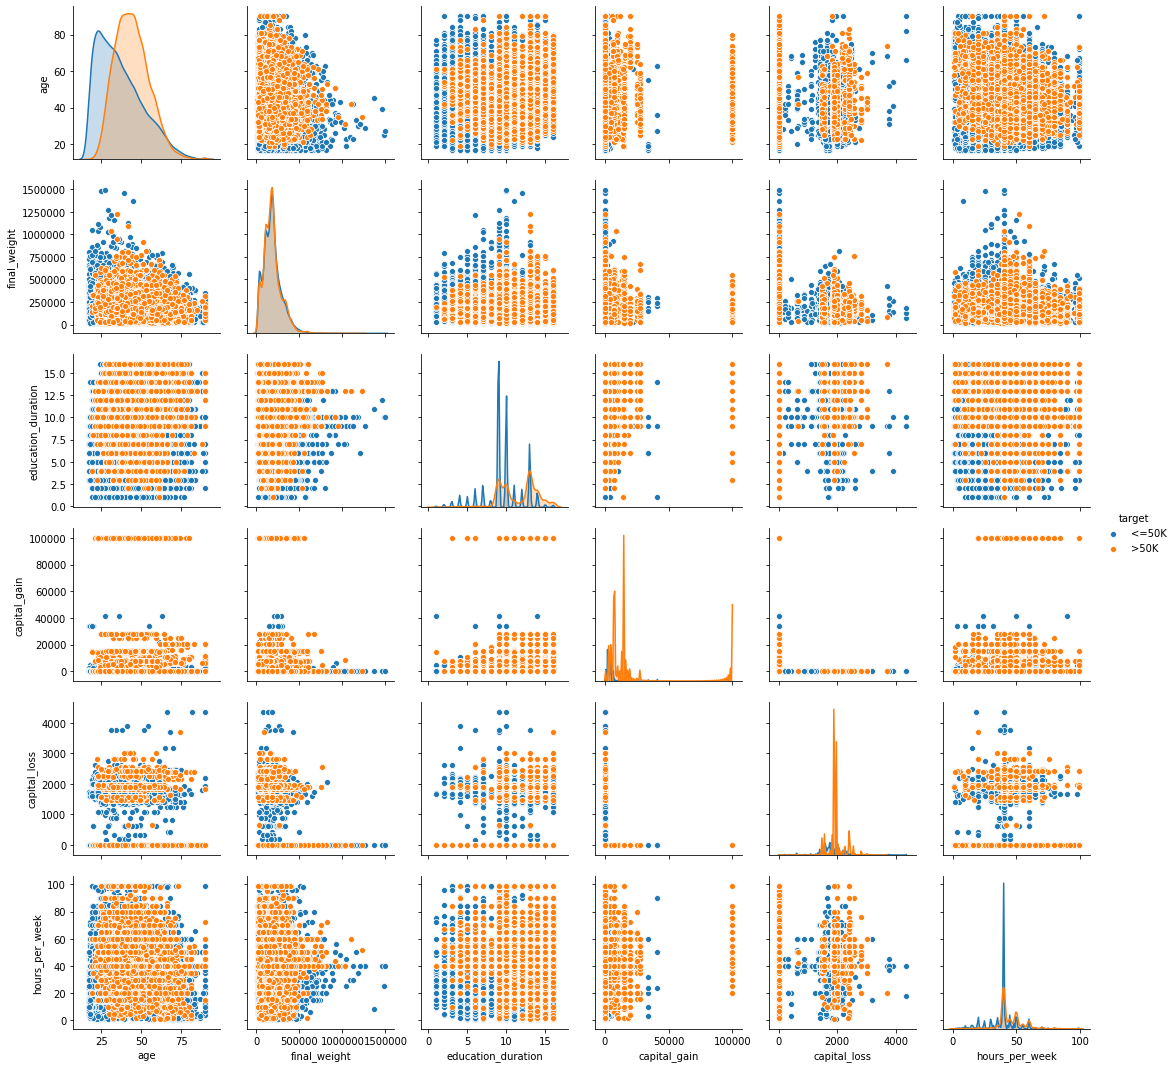

In [0]:
sns_plot = sns.pairplot(df, hue = 'target', size=2.5)
sns_plot.savefig(data_path + "pairplot.png")
plt.show()

# Age vs target

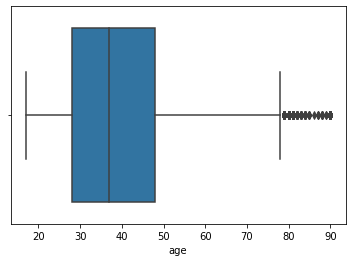

In [0]:
sns.boxplot(df['age'])
plt.show()

In [0]:
print('People whose age > 80 years: ', len(df[df['age'] > 80]))

People whose age > 80 years:  148


Although it seems that the age column has outliers, those values are still in the accepted normal range of human age and they repesent a valiad records. So no need to delete them or clip them.

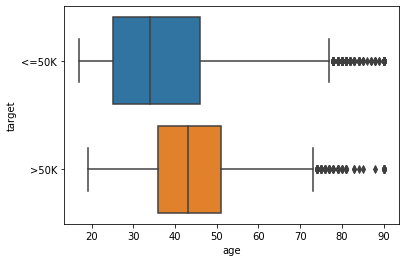

In [0]:
sns.boxplot(x = df['age'], y = df['target'])
plt.show()

The older the person is the higher the chances he/she will earn more than 50K.

In [0]:
print_corr(df, 'age')

Corr between age and the target:  0.23036946784752077


# Workclass vs target

In [0]:
df['workclass'].value_counts()

 Private             33906
 Self-emp-not-inc     3862
 Local-gov            3136
 ?                    2799
 State-gov            1981
 Self-emp-inc         1695
 Federal-gov          1432
 Without-pay            21
 Never-worked           10
Name: workclass, dtype: int64

There are 2799 record with **unknown** workclass. Those records could be:
- Not inserted by the user intentionaly
- Inserted in the database but because of a bug in the system, they were lost
- Inserted as an Other option 


Its difficult to imput those values. The solution could be to assign **other** to those records and create a binary column to idicate that certain row has missing values. This columns tells the model to pay attention to the rows with imputed values 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

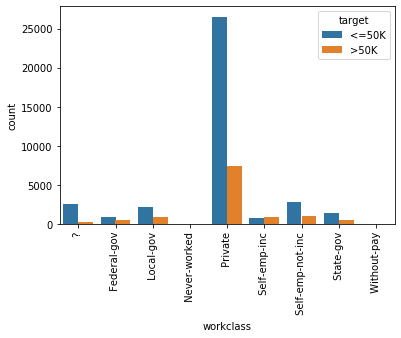

In [0]:
gb = df.groupby(by = ['workclass', 'target']).agg({'age': 'count'})
gb.columns = ['count']
gb = gb.reset_index()
ax = sns.barplot(x = 'workclass', y = 'count', hue = 'target', data = gb)
plt.xticks(rotation = 90)

In [0]:
print_corr(df, 'workclass')

Corr between workclass and the target:  0.18115107631207905


# Final_weight vs target

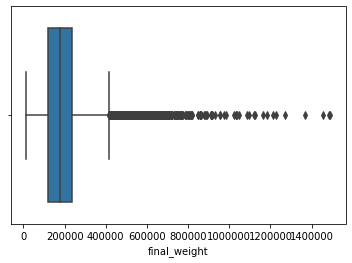

In [0]:
sns.boxplot(x = 'final_weight', data = df)
plt.show()

In [0]:
print('final_weight outliers: ', len(df[df['final_weight'] > 400000]))

final_weight outliers:  1888


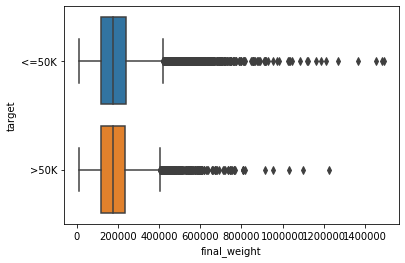

In [0]:
sns.boxplot(x = df['final_weight'], y = df['target'])
plt.show()

In [0]:
print_corr(df, 'final_weight')

Corr between final_weight and the target:  -0.006338859530113216


This column is not discriminative against the target with low correlation as well. It is probabaly not useful for the learning.

# Education vs target

In [0]:
df['education'].value_counts()

 HS-grad         15784
 Some-college    10878
 Bachelors        8025
 Masters          2657
 Assoc-voc        2061
 11th             1812
 Assoc-acdm       1601
 10th             1389
 7th-8th           955
 Prof-school       834
 9th               756
 12th              657
 Doctorate         594
 5th-6th           509
 1st-4th           247
 Preschool          83
Name: education, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

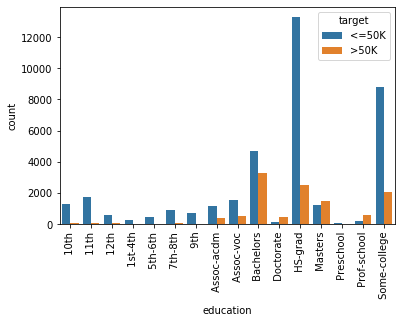

In [0]:
gb = df.groupby(by = ['education', 'target']).agg({'age': 'count'})
gb.columns = ['count']
gb = gb.reset_index()
ax = sns.barplot(x = 'education', y = 'count', hue = 'target', data = gb)
plt.xticks(rotation = 90)

In [0]:
print_corr(df, 'education')

Corr between education and the target:  0.3654521366236938


# Education_duration vs target

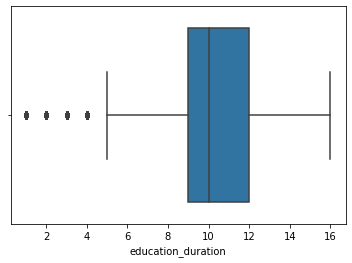

In [0]:
sns.boxplot(x = 'education_duration', data = df)
plt.show()

In [0]:
print('People whose study duration < 5: ', len(df[df['education_duration'] < 5]))

People whose study duration < 5:  1794


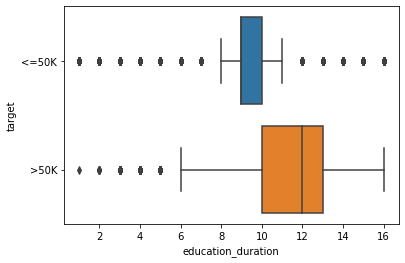

In [0]:
sns.boxplot(x = df['education_duration'], y = df['target'])
plt.show()

In [0]:
print_corr(df, 'education_duration')

Corr between education_duration and the target:  0.3326131306661462


Education_duration is a countious representation of education but it is more correlated with the target

# Marital_status vs target

In [0]:
df['marital_status'].value_counts()

 Married-civ-spouse       22379
 Never-married            16117
 Divorced                  6633
 Separated                 1530
 Widowed                   1518
 Married-spouse-absent      628
 Married-AF-spouse           37
Name: marital_status, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

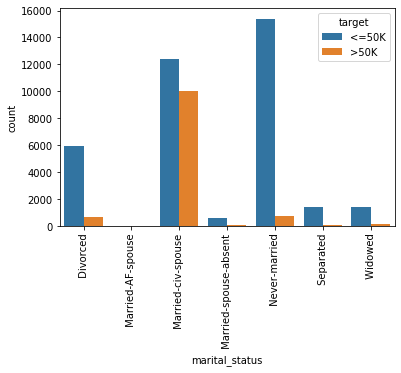

In [0]:
gb = df.groupby(by = ['marital_status', 'target']).agg({'age': 'count'})
gb.columns = ['count']
gb = gb.reset_index()
ax = sns.barplot(x = 'marital_status', y = 'count', hue = 'target', data = gb)
plt.xticks(rotation = 90)

In [0]:
print_corr(df, 'marital_status')

Corr between marital_status and the target:  0.4481697711621431


# Occupation vs target

In [0]:
df['occupation'].value_counts()

 Prof-specialty       6172
 Craft-repair         6112
 Exec-managerial      6086
 Adm-clerical         5611
 Sales                5504
 Other-service        4923
 Machine-op-inspct    3022
 ?                    2809
 Transport-moving     2355
 Handlers-cleaners    2072
 Farming-fishing      1490
 Tech-support         1446
 Protective-serv       983
 Priv-house-serv       242
 Armed-Forces           15
Name: occupation, dtype: int64

There are 2809 records with **unknown** occupation. Those records could be:

- Not inserted by the user intentionaly
- Inserted in the database but because of a bug in the system, they were lost
- Inserted as an Other option and not interpreted correctly by the system

Its difficult to imput those values. The solution could be to assign **other** to those records and create a binary column to idicate that certain row has missing values.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

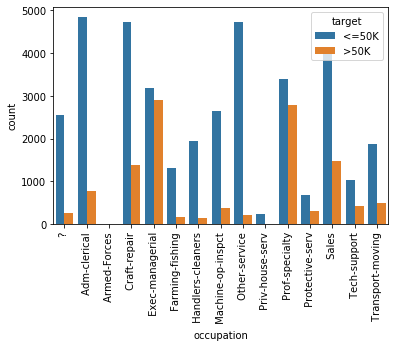

In [0]:
gb = df.groupby(by = ['occupation', 'target']).agg({'age': 'count'})
gb.columns = ['count']
gb = gb.reset_index()
ax = sns.barplot(x = 'occupation', y = 'count', hue = 'target', data = gb)
plt.xticks(rotation = 90)

In [0]:
print_corr(df, 'occupation')

Corr between occupation and the target:  0.34959439912635987


# relationship vs target

In [0]:
df['relationship'].value_counts()

 Husband           19716
 Not-in-family     12583
 Own-child          7581
 Unmarried          5125
 Wife               2331
 Other-relative     1506
Name: relationship, dtype: int64

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

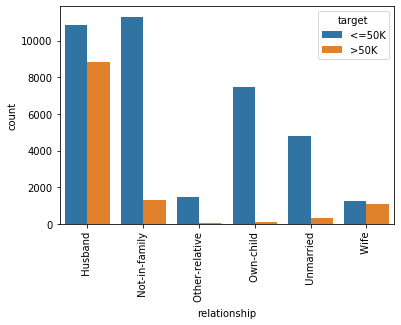

In [0]:
gb = df.groupby(by = ['relationship', 'target']).agg({'age': 'count'})
gb.columns = ['count']
gb = gb.reset_index()
ax = sns.barplot(x = 'relationship', y = 'count', hue = 'target', data = gb)
plt.xticks(rotation = 90)

In [0]:
print_corr(df, 'relationship')

Corr between relationship and the target:  0.45437891144289516


# Race vs target

In [0]:
df['race'].value_counts()

 White                 41762
 Black                  4685
 Asian-Pac-Islander     1519
 Amer-Indian-Eskimo      470
 Other                   406
Name: race, dtype: int64

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

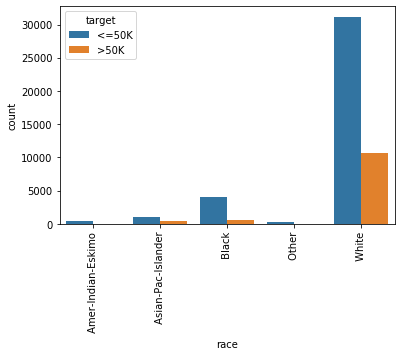

In [0]:
gb = df.groupby(by = ['race', 'target']).agg({'age': 'count'})
gb.columns = ['count']
gb = gb.reset_index()
ax = sns.barplot(x = 'race', y = 'count', hue = 'target', data = gb)
plt.xticks(rotation = 90)

In [0]:
print_corr(df, 'race')

Corr between race and the target:  0.09944731744509899


# Sex vs target

In [0]:
df['sex'].value_counts()

 Male      32650
 Female    16192
Name: sex, dtype: int64

(array([0, 1]), <a list of 2 Text xticklabel objects>)

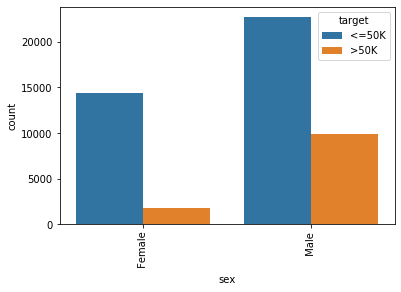

In [0]:
gb = df.groupby(by = ['sex', 'target']).agg({'age': 'count'})
gb.columns = ['count']
gb = gb.reset_index()
ax = sns.barplot(x = 'sex', y = 'count', hue = 'target', data = gb)
plt.xticks(rotation = 90)

In [0]:
print_corr(df, 'sex')

Corr between sex and the target:  0.21453154666546925


# Capital_gain vs target

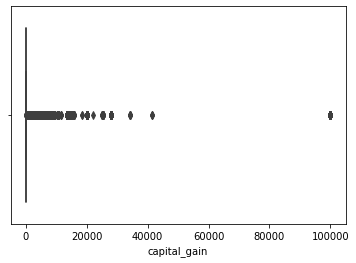

In [0]:
sns.boxplot(x = 'capital_gain', data = df)
plt.show()

In [0]:
print('People with capital_gain > 80000: ', len(df[df['capital_gain'] > 80000]))

People with capital_gain > 80000:  244


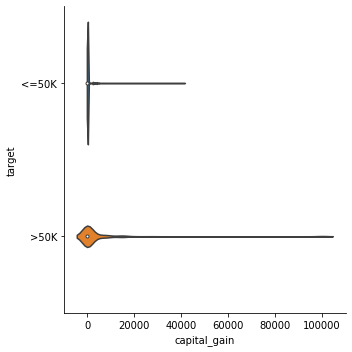

In [0]:
sns.catplot(x = 'capital_gain', y = 'target', data = df, kind="violin")
plt.show()

In [0]:
print_corr(df, 'capital_gain')

Corr between capital_gain and the target:  0.2230130208582356


# Capital_loss vs target

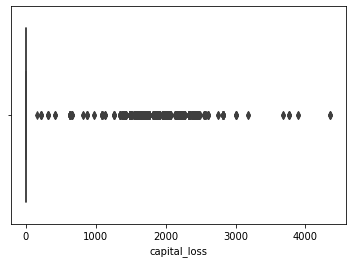

In [0]:
sns.boxplot(x = 'capital_loss', data = df)
plt.show()

In [0]:
print('People with capital_loss > 0: ', len(df[df['capital_loss'] > 0]))

People with capital_loss > 0:  2282


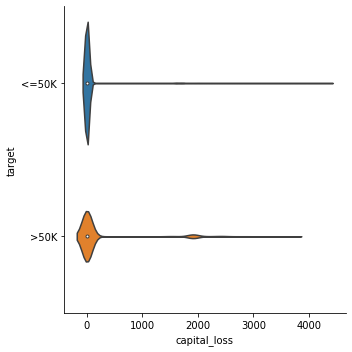

In [0]:
sns.catplot(x = 'capital_loss', y = 'target', data = df, kind="violin")
plt.show()

In [0]:
print_corr(df, 'capital_loss')

Corr between capital_loss and the target:  0.14755448819939188


# Hours_per_week vs target

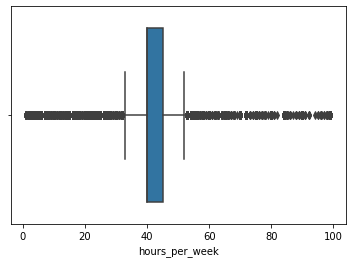

In [0]:
sns.boxplot(x = 'hours_per_week', data = df)
plt.show()

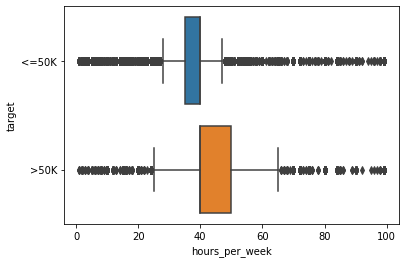

In [0]:
sns.boxplot(x = df['hours_per_week'], y = df['target'])
plt.show()

In [0]:
print_corr(df, 'hours_per_week')

Corr between hours_per_week and the target:  0.22768676056081416


# Native_country vs target

In [0]:
df['native_country'].value_counts()

 United-States                 43832
 Mexico                          951
 ?                               857
 Philippines                     295
 Germany                         206
 Puerto-Rico                     184
 Canada                          182
 El-Salvador                     155
 India                           151
 Cuba                            138
 England                         127
 China                           122
 South                           115
 Jamaica                         106
 Italy                           105
 Dominican-Republic              103
 Japan                            92
 Guatemala                        88
 Poland                           87
 Vietnam                          86
 Columbia                         85
 Haiti                            75
 Portugal                         67
 Taiwan                           65
 Iran                             59
 Nicaragua                        49
 Greece                           49
 

There are 856 records with **unknown** native_country. Those records could be:

- Not inserted by the user intentionaly
- Inserted in the database but because of a bug in the system, they were lost
- Inserted as an Other option and not interpreted correctly by the system

Its difficult to imput those values. The solution could be to assign **other** to those records and create a binary column to idicate that certain row has missing values.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text xticklabel objects>)

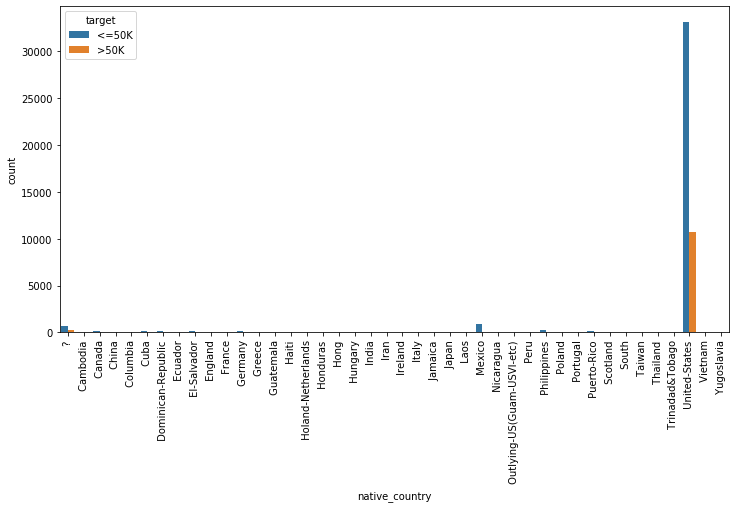

In [0]:
gb = df.groupby(by = ['native_country', 'target']).agg({'age': 'count'})
gb.columns = ['count']
gb = gb.reset_index()
fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(x = 'native_country', y = 'count', hue = 'target', data = gb)
plt.xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]), <a list of 41 Text xticklabel objects>)

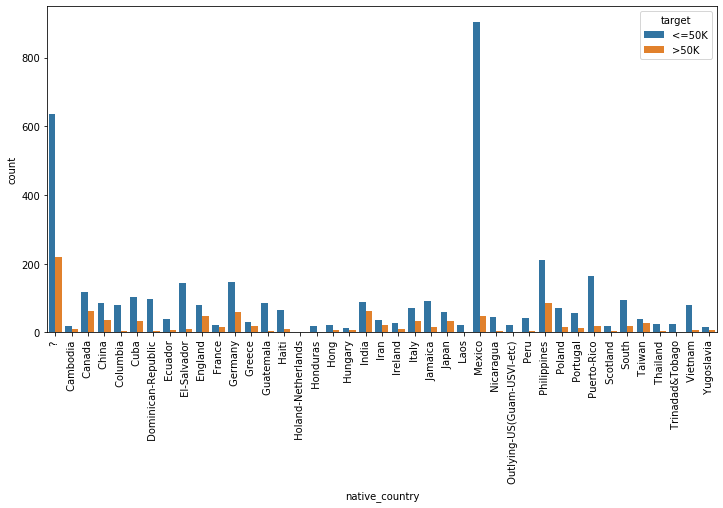

In [0]:
new_gb = gb[gb['count'] < 10692]
fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(x = 'native_country', y = 'count', hue = 'target', data = new_gb)
plt.xticks(rotation = 90)

In [0]:
print_corr(df, 'native_country')

Corr between native_country and the target:  0.09175910125047917


# Correlation Map

In [0]:
for col in df.columns:
    if df[col].dtype == 'object':
        lb = LabelEncoder()
        df[col] = lb.fit_transform(df[col])

In [0]:
corr = df.corr(method = 'spearman')

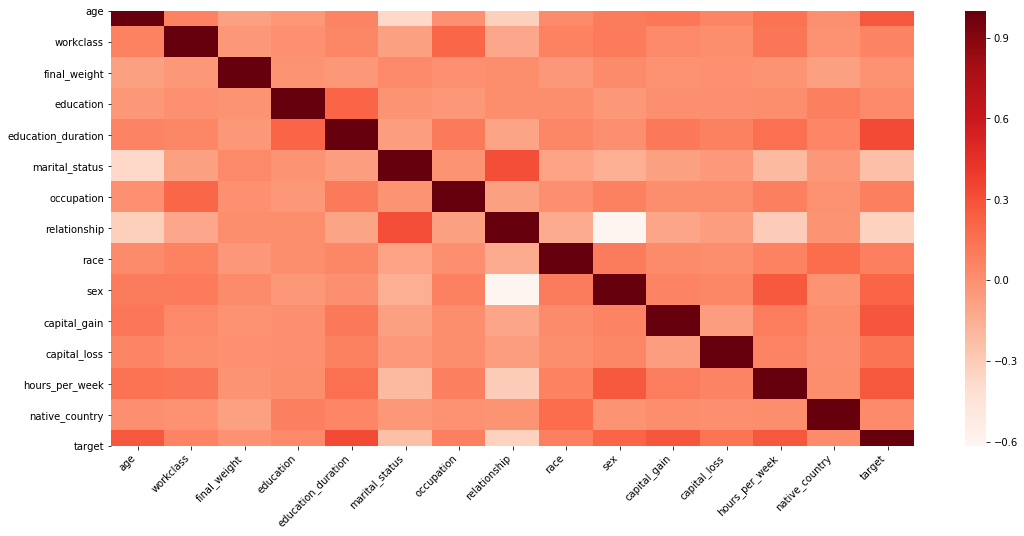

In [0]:
f, ax = plt.subplots(figsize = (18, 8))
ax = sns.heatmap(corr, cmap = plt.cm.Reds)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right'
)
plt.show()

# Baseline Model

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

X = df.drop(columns = ['target', 'education'])
y = df['target']
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(X_tr, y_tr)

y_hat = rf.predict(X_test)
print('accuracy_score: ', accuracy_score(y_test, y_hat))
print('f1_score: ', f1_score(y_test, y_hat))
print('roc_auc_score: ', roc_auc_score(y_test, y_hat))

accuracy_score:  0.8572988466525626
f1_score:  0.6771653543307087
roc_auc_score:  0.7760898343258582


## Feature importance

In [0]:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(X.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Featrue: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Featrue: final_weight         Importance: 0.175
Featrue: age                  Importance: 0.146
Featrue: education_duration   Importance: 0.119
Featrue: capital_gain         Importance: 0.117
Featrue: relationship         Importance: 0.107
Featrue: hours_per_week       Importance: 0.082
Featrue: marital_status       Importance: 0.07
Featrue: occupation           Importance: 0.066
Featrue: workclass            Importance: 0.038
Featrue: capital_loss         Importance: 0.038
Featrue: native_country       Importance: 0.017
Featrue: race                 Importance: 0.014
Featrue: sex                  Importance: 0.011
